**Goal:**

Create a jupyter notebook which will take a Cytoscape network and score it by:
* Applying a Cytoscape layout to the Cytoscape graph
* Translating the Cytoscape network into a Shapely graph
* Counting the edge crossings
* Measuring the distance between connected nodes
* Measuring the distance between unconnected nodes
* Measuring the distances between close nodes and edges
* Returning the score

**Requirements:**
* Cytoscape must be open, and the graph being evaluated must be displayed
* The file `cyto_to_shapely_node_util.ipynb` must be in the `utils` directory under this directory
* The file `cyto_to_shapely_edge_util.ipynb` must be in the `utils` directory under this directory
* The file `full_cyto_to_shapely_util.ipynb` must be in the `utils` directory under this directory

In [55]:
#Imports, constants, global variables
import math
from statistics import *

from math import *
import requests
import urllib.parse
import numpy as np
import matplotlib.pyplot as plt
from py2cytoscape import cyrest
from shapely.geometry import Polygon

%run utils/cyto_to_shapely_node_util.ipynb
%run utils/cyto_to_shapely_edge_util.ipynb
%run utils/full_cyto_to_shapely_util.ipynb

BASE_URL = 'http://localhost:1234/v1/'

cy = cyrest.cyclient()

In [58]:
#Apply a Cytoscape layout to the Cytoscape graph that's currently open
CYTOSCAPE_LAYOUT = 'hierarchical'
CYTOSCAPE_LAYOUT_COLUMN = ''

network_suid = str(cy.network.get_attribute(
    columnList='SUID',
    network='CURRENT'
)[0]['SUID'])

requests.get(BASE_URL 
             + 'apply/layouts/' 
             + CYTOSCAPE_LAYOUT 
             + '/' 
             + str(network_suid)
             + '?'
             + urllib.parse.quote(CYTOSCAPE_LAYOUT_COLUMN)).json()

{'message': 'Layout finished.'}

(5473.822189276486, -4480.3729773901805)
(-833.711166666667, 17980.45783333334)


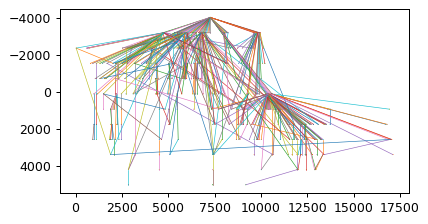

In [70]:
#Translate the Cytoscape network into a Shapely graph
network_suid = str(cy.network.get_attribute(
    columnList='SUID',
    network='CURRENT'
)[0]['SUID'])
view_suid = str(requests.get(BASE_URL + 'networks/views/currentNetworkView').json()['data']['networkViewSUID'])
shapes, lines = full_cyto_to_shapely(network_suid, view_suid)

#View network
fig = plt.figure(1, figsize=(5,5), dpi=90)
ax = fig.add_subplot(111)

coords = []
for shape_info in shapes.values():
    coords.append(shape_info['shape'].exterior.xy)
for coord in coords:
    x, y = coord
    ax.plot(x, y, linewidth=0.5)
    
for line_info in lines.values():
    line = line_info['line']
    ax.plot(*np.array(line).T, linewidth=0.5)
    
ax.set_aspect(1)
ax.set_ylim(ax.get_ylim()[::-1])
ylim = ax.get_ylim()
xlim = ax.get_xlim()
print(ylim)
print(xlim)

In [16]:
#Count the edge crossings
edge_crossings = 0

checked = []
for outer_line_suid, outer_line_info in lines.items():
    checked.append(outer_line_suid)
    outer_line = outer_line_info['line']
    for inner_line_suid, inner_line_info in lines.items():
        if inner_line_suid in checked:
            continue
        inner_line = inner_line_info['line']
        if inner_line.intersects(outer_line):
            edge_crossings += 1
            
possible_edge_crossings = len(checked) * (len(checked) - 1) / 2
edge_crossings_score = (possible_edge_crossings - edge_crossings) / possible_edge_crossings
                
print('Edge Crossings: ' + str(edge_crossings))
print('Edge Crossings Score: ' + str(edge_crossings_score))

Edge Crossings: 18
Edge Crossings Score: 0.9833487511563367


In [33]:
#Count the node overlaps
node_overlaps = 0

checked = []
for outer_shape_suid, outer_shape_info in shapes.items():
    checked.append(outer_shape_suid)
    outer_shape = outer_shape_info['shape']
    for inner_shape_suid, inner_shape_info in shapes.items():
        if inner_shape_suid in checked:
            continue
        inner_shape = inner_shape_info['shape']
        if inner_shape.intersects(outer_shape):
            node_overlaps += 1
    
possible_node_overlaps = len(checked) * (len(checked) - 1) / 2
node_overlaps_score = (possible_node_overlaps - node_overlaps) / possible_node_overlaps

print('Node Overlaps: ' + str(node_overlaps))
print('Node Overlaps Score ' + str(node_overlaps_score))

Node Overlaps: 0
Node Overlaps Score 1.0


In [39]:
#Count the overlaps between nodes and edges
node_edge_overlaps = 0

for shape_suid, shape_info in shapes.items():
    shape = shape_info['shape']
    for line_info in lines.values():
        if shape_suid == line_info['source'] or shape_suid == line_info['target']:
            continue
        if line_info['line'].intersects(shape):
            node_edge_overlaps += 1
            
possible_node_edge_overlaps = (len(shapes) - 2) * len(lines)
node_edge_overlaps_score = (possible_node_edge_overlaps - node_edge_overlaps) / possible_node_edge_overlaps

print('Node-Edge Overlaps: ' + str(node_edge_overlaps))
print('Node-Edge Overlaps Score: ' + str(node_edge_overlaps_score))

Node-Edge Overlaps: 79
Node-Edge Overlaps Score: 0.9399696048632219


In [17]:
#Measure the distance between connected nodes (edge length)
diagonal = sqrt((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2)

def cost(length):#Can have penalty for extremely short edges
    if length < 35:
        return diagonal
    return length

total_edge_length = 0
total_edge_cost = 0

for line_info in lines.values():
    total_edge_length += line_info['line'].length
    total_edge_cost += cost(line_info['line'].length)
    
edge_cost_score = max(0, 1 - total_edge_cost/len(lines)/diagonal)

print('Edge Length: ' + str(total_edge_length))
print('Edge Cost:   ' + str(total_edge_cost))
print('Edge Length Score: ' + str(edge_cost_score))

Edge Length: 9953.794782124047
Edge Cost:   9953.794782124047
Edge Length Score: 0.8509009126152871


In [18]:
#Measure the distance between unconnected nodes
total_node_distance = 0

for outer_shape_suid, outer_shape_info in shapes.items():
    outer_shape = outer_shape_info['shape']
    min_distance = float('Infinity')
    for inner_shape_suid, inner_shape_info in shapes.items():
        inner_shape = inner_shape_info['shape']
        if inner_shape == outer_shape:
            continue
        if inner_shape_suid in outer_shape_info['neighbors']:
            continue
        distance = outer_shape.distance(inner_shape)
        if distance < min_distance:
            min_distance = distance
    total_node_distance += min_distance
    
diagonal = sqrt((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2)
node_distance_score = total_node_distance / diagonal / len(shapes)

print('Node Distance: ' + str(total_node_distance))
print('Node Distance Score: ' + str(node_distance_score))          

Node Distance: 1613.4493450386212
Node Distance Score: 0.03786328067891307


In [19]:
#Measure the distance between a node and the closest edge
total_node_edge_distance = 0

for shape_suid, shape_info in shapes.items():
    shape = shape_info['shape']
    min_distance = float('Infinity')
    for line_info in lines.values():
        if line_info['source'] == shape_suid or line_info['target'] == shape_suid:
            continue
        distance = shape.distance(line_info['line'])
        if distance < min_distance:
            min_distance = distance
    total_node_edge_distance += min_distance
    
diagonal = sqrt((xlim[1] - xlim[0]) ** 2 + (ylim[1] - ylim[0]) ** 2)
node_edge_distance_score = total_node_edge_distance / diagonal / len(shapes)

print('Node-Edge Distance: ' + str(total_node_edge_distance))
print('Node-Edge Distance Score: ' + str(node_edge_distance_score))

Node-Edge Distance: 1251.9894750616193
Node-Edge Distance Score: 0.029380797759206007


In [41]:
#Measure the number of downward pointing edges (more than 15 degrees below horizontal)
downward_edges = 0
THRESHOLD = 5 * math.pi / 180

def _is_downward_pointing(source_x, source_y, target_x, target_y):
    if source_y > target_y:
        return False
    dx = abs(target_x - source_x)
    dy = abs(target_y - source_y)
    if dx == 0:
        return True
    if math.atan(dy / dx) > THRESHOLD:
        return True
    return False

for line_info in lines.values():
    source_suid = line_info['source']
    target_suid = line_info['target']
    if _is_downward_pointing(
        shapes[source_suid]['x'],
        shapes[source_suid]['y'],
        shapes[target_suid]['x'],
        shapes[target_suid]['y']
    ):
        downward_edges += 1
        
downward_edges_score = downward_edges / len(lines)

print('Downward Edges: ' + str(downward_edges))
print('Downward Edges Score: ' + str(downward_edges_score))

Downward Edges: 1
Downward Edges Score: 0.02127659574468085


In [68]:
#Measure lined up ness
'''
def find_min_sum_of_var(variances):
    #Add pseudocount
    pseudocount = max(variances) / 1000
    if pseudocount == 0:
        return 0
    variances.insert(0, 0)
    variances = [vari + pseudocount for vari in variances]
            
    #Calculate fold increase
    fold_increase = []
    for i in range(len(variances) - 1):
        fold_increase.append(variances[i+1] / variances[i])
    return variances[fold_increase.index(max(fold_increase))] - pseudocount

#Pre-process data
heights = []
for shape_info in shapes.values():
    heights.append(shape_info['height'])
min_height = min(heights)
magnitude = floor(log10(min_height / 100))

data = {}
if magnitude > 0:
    for shape_suid, shape_info in shapes.items():
        data[shape_suid] = round(shape_info['y'] / 10 ** magnitude) * 10 ** magnitude
else:
    for shape_suid, shape_info in shapes.items():
        data[shape_suid] = round(shape_info['y'], -magnitude)
    
#Execute clustering and calculate variances
clusters = [{'members': [item[0]], 'values': [item[1]]} for item in data.items()]
iterations = 0
variances = []

while len(clusters) > 1:
    iterations += 1
    #Find closest clusters
    smallest_diff = float('Infinity')
    i_coord = None
    j_coord = None
    for i in range(len(clusters)-1):
        for j in range(i+1, len(clusters)):
            diff = abs(mean(clusters[i]['values']) - mean(clusters[j]['values']))
            if diff < smallest_diff:
                smallest_diff = diff
                i_coord = i
                j_coord = j
    #Merge closest clusters
    clusters[i_coord]['members'] += clusters[j_coord]['members']
    clusters[i_coord]['values'] += clusters[j_coord]['values']
    del(clusters[j_coord])
    
    sum_of_variances_within = 0
    for cluster in clusters:
        if len(cluster['members']) > 1:
            sum_of_variances_within += pvariance(cluster['values'])

    variances.append(sum_of_variances_within)
    
min_sum_of_variance = find_min_sum_of_var(variances)
min_sum_of_variance_score = 1 - (min_sum_of_variance / ((ylim[1] - ylim[0]) ** 2 / 4))
print(min_sum_of_variance_score)
'''

0.9997477112072213


In [75]:
#Aspect ratio
MIN_ASPECT_RATIO = 0.5
MAX_ASPECT_RATIO = 2

ratio = (xlim[1] - xlim[0]) / (ylim[0] - ylim[1])

if ratio > MAX_ASPECT_RATIO:
    ratio = 1 / ratio
    min_ratio = 1 / MAX_ASPECT_RATIO
    aspect_ratio_score = ratio / min_ratio
elif ratio < MIN_ASPECT_RATIO:
    min_ratio = MIN_ASPECT_RATIO
    aspect_ratio_score = ratio / min_ratio
else:
    aspect_ratio_score = 1

print(aspect_ratio_score)

1


In [76]:
#Print total scores
EDGE_CROSSINGS_WEIGHT = 1
NODE_OVERLAPS_WEIGHT = 1
NODE_EDGE_OVERLAPS_WEIGHT = 1
EDGE_LENGTH_WEIGHT = 1
NODE_DISTANCE_WEIGHT = 1
NODE_EDGE_DISTANCE_WEIGHT = 1
DOWNWARD_EDGE_WEIGHT = 1
ASPECT_RATIO_WEIGHT = 1
total_weight = (EDGE_CROSSINGS_WEIGHT 
               + NODE_OVERLAPS_WEIGHT
               + NODE_EDGE_OVERLAPS_WEIGHT 
               + EDGE_LENGTH_WEIGHT 
               + NODE_DISTANCE_WEIGHT 
               + NODE_EDGE_DISTANCE_WEIGHT 
               + DOWNWARD_EDGE_WEIGHT
               + ASPECT_RATIO_WEIGHT)

weighted_edge_crossings_score = EDGE_CROSSINGS_WEIGHT * edge_crossings_score / total_weight
weighted_node_overlaps_score = NODE_OVERLAPS_WEIGHT * node_overlaps_score / total_weight
weighted_node_edge_overlaps_score = NODE_EDGE_OVERLAPS_WEIGHT * node_edge_overlaps_score / total_weight
weighted_edge_cost_score = EDGE_LENGTH_WEIGHT * edge_cost_score / total_weight
weighted_node_distance_score = NODE_DISTANCE_WEIGHT * node_distance_score / total_weight
weighted_node_edge_distance_score = NODE_EDGE_DISTANCE_WEIGHT * node_edge_distance_score / total_weight
weighted_downward_edges_score = DOWNWARD_EDGE_WEIGHT * downward_edges_score / total_weight
weighted_aspect_ratio_score = ASPECT_RATIO_WEIGHT * aspect_ratio_score / total_weight
total_score = weighted_edge_crossings_score + weighted_edge_cost_score + weighted_node_distance_score + weighted_node_edge_distance_score + weighted_aspect_ratio_score

print('Raw Edge Crossings Score:     ' + str(edge_crossings_score))
print('Raw Node Overlaps Score:      ' + str(node_overlaps_score))
print('Raw Node Edge Overlaps Score: ' + str(node_edge_overlaps_score))
print('Raw Edge Length Score:        ' + str(edge_cost_score))
print('Raw Node Distance Score:      ' + str(node_distance_score))         
print('Raw Node-Edge Distance Score: ' + str(node_edge_distance_score))
print('Raw Downward Edges Score:     ' + str(downward_edges_score))
print('Raw Aspect Ratio Score:       ' + str(aspect_ratio_score))
print()
print('Weighted Edge Crossings Score:     ' + str(weighted_edge_crossings_score))
print('Weighted Node Overlaps Score:      ' + str(weighted_node_overlaps_score))
print('Weighted Node Edge Overlaps Score: ' + str(weighted_node_edge_overlaps_score))
print('Weighted Edge Length Score:        ' + str(weighted_edge_cost_score))
print('Weighted Node Distance Score:      ' + str(weighted_node_distance_score))         
print('Weighted Node-Edge Distance Score: ' + str(weighted_node_edge_distance_score))
print('Weighted Downward Edges Score      ' + str(weighted_downward_edges_score))
print('Weighted Aspect Ratio Score        ' + str(weighted_aspect_ratio_score))
print()
print('Total Score: ' + str(total_score))

Raw Edge Crossings Score:     0.9833487511563367
Raw Node Overlaps Score:      1.0
Raw Node Edge Overlaps Score: 0.9399696048632219
Raw Edge Length Score:        0.8509009126152871
Raw Node Distance Score:      0.03786328067891307
Raw Node-Edge Distance Score: 0.029380797759206007
Raw Downward Edges Score:     0.02127659574468085
Raw Aspect Ratio Score:       1

Weighted Edge Crossings Score:     0.12291859389454209
Weighted Node Overlaps Score:      0.125
Weighted Node Edge Overlaps Score: 0.11749620060790274
Weighted Edge Length Score:        0.10636261407691089
Weighted Node Distance Score:      0.004732910084864134
Weighted Node-Edge Distance Score: 0.003672599719900751
Weighted Downward Edges Score      0.0026595744680851063
Weighted Aspect Ratio Score        0.125

Total Score: 0.36268671777621786
